In [4]:
%matplotlib inline

# define relevant packages; among others: JIRA API
import pandas as pd
import numpy as np
from jira import JIRA 
import matplotlib.pyplot as plt
import mwtools as mt

import seaborn as sns


# ToDos
- [ ] create filters and apply them to a dataframe wo/changing the dataframe itself 

/Example:/
```
price_filter = df.loc[:, 'price'] <= 3000000
df.loc[price_filter, 'price'].hist(bins = 30)
```
- [ ] measure balance sheet for provided hours and billed hours

 # AERQ Business Owner Reporting Notebook

 ## CMS related reports

### Procon hours

#### Monthly booked hours in a table

---
** Attention: currently, the below figures come from a test excel sheet only! **
** They do currently not reflect any real spent CMS effort **

---

In [2]:
df_procon = pd.read_excel('./AERQ.commercials.overview.xlsx', sheet_name='Procon LTE Data', usecols="A:L")
df_procon.shape

(701, 12)

In [3]:
print (df_procon['LE-Bezeichnung'].value_counts())
#from all Procon LEs, filter the CMS entries only
#cms_filter = df_procon['LE-Bezeichnung'] == 'AERQ Product'
cms_filter = (df_procon['LE-Bezeichnung'] == 'Quality Mgnmtt, Integration & System Testing BUD') | (df_procon['LE-Bezeichnung'] == 'Planning & Alignment BUD') | (df_procon['LE-Bezeichnung'] == 'Applications & Services BUD') | (df_procon['LE-Bezeichnung'] == 'Core BUD')
# and check, how many entries are affected
cms_filter.shape


Applications & Services BUD                         126
Planning & Alignment BUD                            104
AERQ ModServer                                       88
AERQ Consulting                                      88
AERQ SW Architect & Deploy FRA                       76
AERQ OpsUI BUD                                       63
AERQ Product                                         50
AERQ Sales Support                                   41
AERQ SW Architect & Deploy BUD Jun                   21
AERQ Virtual Aircraft                                13
AERQ SW Architect & Deploy BUD Prof                  10
AERQ SW Architect & Deploy BUD Sen                    7
RFC BC Core Mod Experte                               5
Quality Mgnmtt, Integration & System Testing BUD      3
AERQ CoTo-OpsUI BUD                                   3
RFC BC Core Mod Sen Entw                              2
Core BUD                                              1
Name: LE-Bezeichnung, dtype: int64


(701,)

In [4]:
# get the number of employees that have booked hours for the filtered Procon LE
no_staff = len(df_procon.loc[cms_filter, ['Mitarbeiter-Name']].value_counts())
# sum up the booked hours and print 'em out
no_hours = df_procon.loc[cms_filter, ['Stunden']].sum()
print(str(no_staff)+' colleagues have booked a total of '+str(no_hours))
df_procon.loc[cms_filter, :].groupby(by=['Export-Datum', 'Mitarbeiter-Name'])[['Stunden']].sum()

9 colleagues have booked a total of Stunden    5597.88
dtype: float64


Stunden
Export-Datum Mitarbeiter-Name         
2021-01-27   Antal, Peter        77.50
             Banhidy, Attila     35.95
             Hato, Beata        120.60
             Kemeny, Viktor     105.50
             Kis, Norbert       105.00
...                                ...
2021-10-27   Hato, Beata         48.00
             Kemeny, Viktor      83.55
             Kis, Norbert        30.00
             Nagy, Laszlo       145.00
             Rozsas, Gergely     21.00

[85 rows x 1 columns]

In [5]:
print (df_procon['Stunden'].value_counts())


0.00     52
1.00     38
2.00     37
4.00     27
1.50     23
         ..
26.40     1
12.75     1
66.00     1
50.95     1
9.25      1
Name: Stunden, Length: 249, dtype: int64


#### Monthly booked hours in a chart (2020)

No handles with labels found to put in legend.


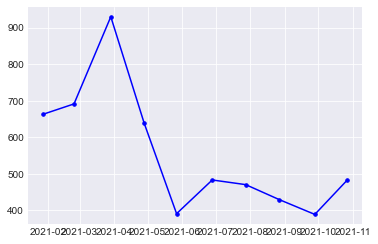

In [6]:
#type(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum())
#plt.style.available
plt.style.use('seaborn-darkgrid')
plt.legend(loc='center right')
df_cms = df_procon.loc[cms_filter, :]
#plt.plot(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum(), c='b', marker = '.', markersize=7)
plt.plot(df_cms.groupby(by=['Export-Datum'])[['Stunden']].sum(), c='b', marker = '.', markersize=7)

 ### Velocity per product in current Sprint: AERQ, DISP, BC

In [2]:
# JQL: retrieve all tickets in current Sprint
search_string = 'project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint'
#search_string = 'project = "SwM@BoardConnect IFEC Portal CMS" AND Sprint in (13887)'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint
```

In [3]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
print(search_string)
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)



project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint


#### Velocity table and chart per category

The chart shows tickets in current Sprint

            Story Points      %
Labels                         
AERQ                53.0  61.63
BC                  11.0  12.79
DISP@LH777          22.0  25.58


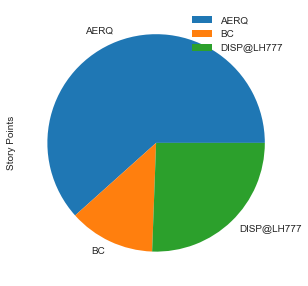

In [9]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


#### Tickets in current Sprint

In [10]:
# Width of the display in characters. If set to None and pandas will correctly auto-detect the width.
pd.set_option('display.width', None)
print (df[['Key', 'Story Points', 'Labels']])

               Key  Story Points      Labels
0   BCIFCPCMS-4853           NaN          BC
1   BCIFCPCMS-5042           NaN          BC
2   BCIFCPCMS-5020           5.0        AERQ
3   BCIFCPCMS-5048           NaN        AERQ
4   BCIFCPCMS-5002           3.0  DISP@LH777
5   BCIFCPCMS-5066           NaN        AERQ
6   BCIFCPCMS-5061           NaN          BC
7   BCIFCPCMS-5018           0.0        AERQ
8   BCIFCPCMS-4812           8.0  DISP@LH777
9   BCIFCPCMS-4889          13.0        AERQ
10  BCIFCPCMS-4959           5.0          BC
11  BCIFCPCMS-4997           2.0  DISP@LH777
12  BCIFCPCMS-4996           2.0  DISP@LH777
13  BCIFCPCMS-5067           NaN          BC
14  BCIFCPCMS-5019           1.0        AERQ
15  BCIFCPCMS-5027           5.0        AERQ
16  BCIFCPCMS-5071           NaN        AERQ
17  BCIFCPCMS-5072           NaN        AERQ
18  BCIFCPCMS-5055           NaN        AERQ
19  BCIFCPCMS-5028           3.0        AERQ
20  BCIFCPCMS-5063           3.0          BC
21  BCIFCP

 ### Velocity per product in refined items: AERQ, DISP, BC

In [11]:
# JQL: get all tickets which have label "refined" and that are in the backlog
search_string = 'project = BCIFCPCMS AND issuetype not in subtaskIssueTypes() AND issuetype != Epic AND resolution = Unresolved AND (Sprint = EMPTY OR Sprint not in (openSprints(), futureSprints())) AND labels in ("refined")'

**JQL Statement**
```
project = BCIFCPCMS AND issuetype not in subtaskIssueTypes() AND issuetype != Epic AND resolution = Unresolved AND (Sprint = EMPTY OR Sprint not in (openSprints(), futureSprints())) AND labels in ("refined")
```

In [12]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)


#### Velocity table and chart per category

The chart shows refined items in Backlog

            Story Points      %
Labels                         
BC                 566.0  94.49
DISP@LH777          33.0   5.51


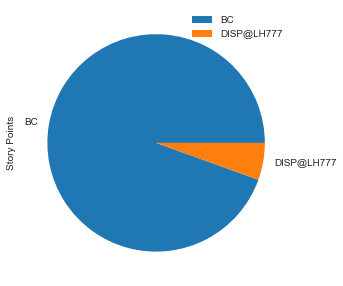

In [13]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in future Sprints: AERQ, DISP, BC

In [14]:
# JQL: get all non-closed tickets from future Sprints (thus: Refined Sprint (doesn't exist any longer; instead, label "refined" is used), existing Sprints > current one)
search_string = 'project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint
```

In [15]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)



#### Velocity table and chart per category

The chart shows tickets in future Sprints (refined items that have already been planned in future Sprints)

            Story Points      %
Labels                         
AERQ                70.0  60.87
BC                  37.0  32.17
DISP@LH777           8.0   6.96


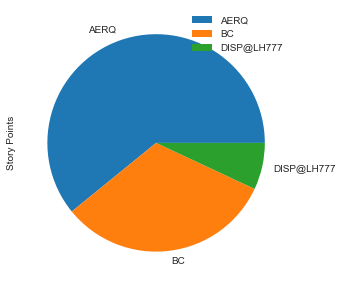

In [16]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in past month per category: AERQ, DISP, BC

In [6]:
from datetime import date, timedelta

previous_month = date.today().replace(day=1) - timedelta(days=1)
#pre_previous_month = previous_month.replace(day=1) - timedelta(days=1)
#pre_pre_previous_month = pre_previous_month.replace(day=1) - timedelta(days=1)
#print(pre_pre_previous_month)
#previous_month = pre_pre_previous_month
# create DataFrame with relevant attributes from which further reports are derived
search_string = ('project = BCIFCPCMS AND '
'status changed TO (resolved, done, closed) '
'AFTER "' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + '01" '
'BEFORE "' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + str(previous_month.day) + '" '
'ORDER BY  updated DESC')

**JQL Statement**
```
project = BCIFCPCMS AND status changed to (resolved, done, closed) after "yyyy/mm-1/1" before "yyyy/mm-1/<end_of_month>" ORDER BY updated DESC" 
```

In [7]:
df = pd.DataFrame()
print(search_string)
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)


project = BCIFCPCMS AND createdDate >= startOfYear() AND status changed TO (resolved, done, closed)


#### Velocity table and chart per category

10 2021
            Story Points      %
Labels                         
AERQ               635.0  48.29
BC                 520.0  39.54
DISP@LH777         160.0  12.17


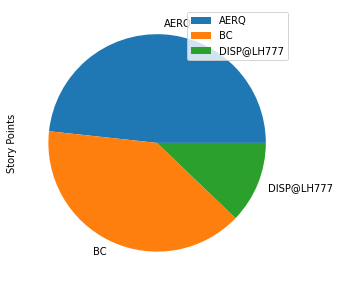

In [8]:
    # group selected tickets (previous month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print (str(previous_month.month) + ' ' + str(previous_month.year))
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in current month per category: AERQ, DISP, BC

In [22]:
current_month = date.today()
search_string = ('project = BCIFCPCMS AND '
'status changed TO (resolved, done, closed) '
'AFTER "' + str(current_month.year) + '/' + str(current_month.month) + '/' + '01" '
'BEFORE "' + str(current_month) + '" '
'ORDER BY  updated DESC')

**JQL Statement**
```
project = BCIFCPCMS AND status changed to (resolved, done, closed) after "yyyy/mm/1" before "yyyy/mm-1/<today>" ORDER BY updated DESC 
```

In [23]:
df = pd.DataFrame()
print(search_string)
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)


project = BCIFCPCMS AND status changed TO (resolved, done, closed) AFTER "2021/11/01" BEFORE "2021-11-16" ORDER BY  updated DESC


#### Velocity table and chart per category

11 2021
            Story Points      %
Labels                         
AERQ                36.0  70.59
BC                   6.0  11.76
DISP@LH777           9.0  17.65


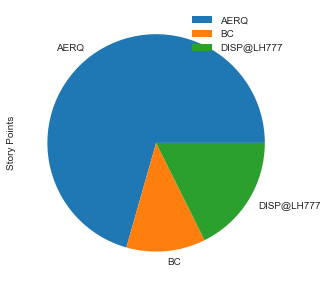

In [24]:
    # group selected tickets (current month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    if df.empty:
        print('In current month, no tickets have been processed so far')
    else:
        df_new = df.groupby('Labels')[['Story Points']].sum()
        # add a Velocity's percentage value per category
        df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
        print (str(current_month.month) + ' ' + str(current_month.year))
        print(df_new)
        plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


In [5]:
search_string = 'project = "SwM@BoardConnect IFEC Portal CMS" AND type = Task AND createdDate >= startOfYear() AND issueFunction in aggregateExpression("timespent") ORDER BY sprint'

**JQL Statement**
```
project = "SwM@BoardConnect IFEC Portal CMS" AND type = Task AND createdDate >= startOfYear() ORDER BY sprint
```

In [8]:
df = pd.DataFrame()
print(search_string)
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
    sum_tasks = 0
    for index, row in df.iterrows():
        if float(row['Time spent']) > 0:
            #print(float(row['Time spent']))
            sum_tasks += row['Time spent']  
            #print(sum_tasks) 
        print(f'Index: {index}, row: {row.values}')
    #print(sum_tasks)
    sum_tasks = sum_tasks / 3600
    print('Time spent on tasks (hours): ' + str(sum_tasks))
except Exception as e:
    print(e)
# dump DataFrame to CSV file
df.to_csv('./BCIFCPCMS_tasks.csv', index=False)


project = "SwM@BoardConnect IFEC Portal CMS" AND type = Task AND createdDate >= startOfYear() AND issueFunction in aggregateExpression("timespent") ORDER BY sprint
Index: 0, row: ['BCIFCPCMS-4683' 'SU | Side Menu not visible on RUS page'
 '2021-04-19T09:34:23.000+0000' '2021-04-19T10:18:43.000+0000' nan
 'Closed' 'BC' 600.0]
Index: 1, row: ['BCIFCPCMS-4678' 'Referencing an internal PDF from a Link content type'
 '2021-04-16T09:38:29.000+0000' '2021-04-19T09:03:55.000+0000' nan
 'Closed' 'BC' 3600.0]
Index: 2, row: ['BCIFCPCMS-4666' 'SU support in Sprint 145'
 '2021-04-09T13:50:37.000+0000' '2021-04-19T09:04:00.000+0000' nan
 'Closed' 'BC' 14640.0]
Index: 3, row: ['BCIFCPCMS-4700' 'SU | CMS meta-data export partially fails'
 '2021-04-22T11:00:11.000+0000' '2021-04-26T07:14:31.000+0000' nan
 'Closed' 'BC' 900.0]
Index: 4, row: ['BCIFCPCMS-4701' 'Compatibilty question ' '2021-04-23T07:37:39.000+0000'
 '2021-04-23T11:17:58.000+0000' nan 'Closed' 'BC' 900.0]
Index: 5, row: ['BCIFCPCMS-4691'

No handles with labels found to put in legend.


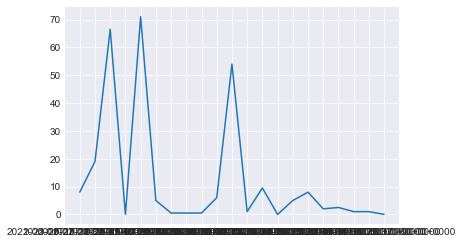

In [28]:

plt.style.use('seaborn-darkgrid')
plt.legend(loc='center right')
#plt.plot(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum(), c='b', marker = '.', markersize=7)
plt.plot(df.groupby(by=['Created'])[['Time spent']].sum()/3600)